# Starbucks clustering with DBSCAN

In this project, we will apply hierarchical clustering to a dataset containing the locations of all Starbucks in the U.S. Then we will redo the process using DBSCAN (Density-based spatial clustering of applications with noise).

Note: this assignment uses geographical data and maps, which will require the use of two specific packages: haversine and plotly. Both of these can be pip installed.

In [ ]:
%matplotlib inline
!pip install haversine

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram
from haversine import haversine
import plotly.express as px


Below are some convenience functions for calculating geographical distance matrices using lat-long data and plotting a dendrogram by combining a scikit-learn model with scipy's dendrogram plotting functionality.

In [ ]:
def geo_sim_matrix(df, col_name = 'Coordinates'):
    """
    A function that computes a geographical distance matrix (in miles).
    Each row in the dataframe should correspond to one location.
    In addition, the dataframe must have a column containing the lat-long of each location as a tuple (i.e. (lat, long)).
    
    Parameters:
        df (pandas dataframe): an nxm dataframe containing the locations to compute similarities between.
        col (string): the name of the column containing the lat-long tuples.
        
    Returns:
        distance (pandas dataframe): an nxn distance matrix between the geographical coordinates of each location.
    """
    
    df = df.copy()
    df.reset_index(inplace=True)
    haver_vec = np.vectorize(haversine, otypes=[np.float32])
    distance = df.groupby('index').apply(lambda x: pd.Series(haver_vec(df[col_name], x[col_name])))
    distance = distance / 1.609344
    distance.columns = distance.index
    
    return distance


def plot_dendrogram(model, **kwargs):
    """
    A basic function for plotting a dendrogram. Sourced from the following link:
    https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
    
    Parameters:
        model (object of class sklearn.cluster.hierarchical.AgglomerativeClustering): a fitted scikit-learn hierarchical clustering model.
    
    Output: a dendrogram based on the model based in the parameters.
    
    Returns: N/A    
    """
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## data preparation

This dataset contains the latitude and longitude (as well as several other details we will not be using) of every Starbucks in the world as of February 2017. Each row consists of the following features, which are generally self-explanatory:

- Brand
- Store Number
- Store Name
- Ownership Type
- Street Address
- City
- State/Province
- Country
- Postcode
- Phone Number
- Timezone
- Longitude
- Latitude


In [ ]:
starbucks = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/starbucks_locations.csv')


In [ ]:
starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


We'll begin by narrowing down the dataset to a specific geographic area of interest. Since we will need to manually compute a distance matrix, which will be on the order of $n^{2}$ in terms of size, I recommend choosing an area with 3000 or less locations. I will choose the state of Texas, since I plan to move there in a few weeks.


In [ ]:
tx_starbucks = starbucks.loc[starbucks['State/Province'] == 'TX',:].copy()
tx_starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
23039,Starbucks,26805-245287,Market Street #679 - Abilene,Licensed,4450 Buffalo Gap Road,Abilene,TX,US,79606,(325) 695-5300,GMT-06:00 America/Chicago,-99.76,32.40
23040,Starbucks,13699-107990,14th & Barrow,Company Owned,1389 Barrow,Abilene,TX,US,796055171,325-692-4765,GMT-06:00 America/Chicago,-99.76,32.43
23041,Starbucks,6637-69140,Buffalo Gap & Hwy. 83,Company Owned,4150 Buffalo Gap Road,Abilene,TX,US,796057232,325-793-2197,GMT-06:00 America/Chicago,-99.76,32.40
23042,Starbucks,29138-252016,351 & Enterprise,Company Owned,2626 Enterprise Drive,Abilene,TX,US,79601,3257257496,GMT-06:00 America/Chicago,-99.69,32.48
23043,Starbucks,22171-200104,Aramark @ Abilene Christian Univers,Licensed,760 Library Court,Abilene,TX,US,79699,325-674-2316,GMT-06:00 America/Chicago,-99.70,32.39


In [ ]:
tx_starbucks.shape

(1042, 13)

The haversine package takes tuples with 2 numeric elements and interprets them as lat-long to calculate distance, so we will add a new column called "Coordinates" that converts the lat and long in each row into a tuple. In other words, the last two columns of the dataframe initially look like this:

**Latitude, Longitude**  
-121.64, 39.14  
-116.40, 34.13  
...

After adding the new column, the last three columns should look like this:

**Latitude, Longitude, Coordinates**  
-121.64, 39.14, (-121.64, 39.14)  
-116.40, 34.13, (-116.40, 34.13)  
...

In [ ]:
# The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together,
# and then the second item in each passed iterator are paired together etc.

tx_starbucks['Coordinates'] = list(zip(tx_starbucks['Latitude'], tx_starbucks['Longitude']))

Now we calculate the distance matrix using the starter code/function geo_sim_matrix() provided earlier in the notebook. It assumes the column containing the coordinates for each location is called "Coordinates"; examine the docstring for more details.

In [ ]:
dist_matrix = geo_sim_matrix(tx_starbucks)
dist_matrix.head()

index,23039,23040,23041,23042,23043,23044,23045,23046,23047,23048,23049,23050,23051,23052,23053,23054,23055,23056,23057,23058,23059,23060,23061,23062,23063,23064,23065,23066,23067,23068,23069,23070,23071,23072,23073,23074,23075,23076,23077,23078,...,24041,24042,24043,24044,24045,24046,24047,24048,24049,24050,24051,24052,24053,24054,24055,24056,24057,24058,24059,24060,24061,24062,24063,24064,24065,24066,24067,24068,24069,24070,24071,24072,24073,24074,24075,24076,24077,24078,24079,24080
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23039,0.000000,2.072803,0.000000,6.871257,3.567982,5.068387,173.309638,174.017858,175.153025,185.221559,186.092025,187.303858,186.856356,187.416421,184.442115,185.221559,185.390821,184.269250,338.252875,337.895048,225.553154,229.253108,229.516178,227.665281,155.481710,153.585985,155.982212,157.055826,155.557570,153.824024,153.585985,154.401838,154.401838,150.935468,155.982212,156.950355,154.325276,150.357862,155.314875,155.022897,...,291.496153,294.694712,153.946078,261.536989,257.927924,260.402050,261.478888,259.887762,260.402050,294.502070,293.923915,166.044024,162.189392,164.618519,165.460768,165.495982,162.189392,149.330774,149.330774,170.326950,170.326950,116.956440,116.956440,117.359322,337.519244,334.899427,337.039335,337.039335,336.208425,443.158339,124.579065,123.452052,287.552509,297.322892,161.367319,190.185266,190.185266,191.319181,189.051692,191.886262
23040,2.072803,0.000000,2.072803,5.347001,4.459515,3.577176,172.847572,173.549232,174.687072,184.669876,185.504351,186.765259,186.286090,186.847671,183.872910,184.669876,184.831913,183.707308,339.493000,339.123530,223.773766,227.507492,227.766390,225.901803,155.221076,153.276191,155.667232,156.697117,155.287844,153.551824,153.276191,154.130472,154.130472,150.659029,155.667232,156.600549,154.063069,150.080561,155.007963,154.687825,...,292.603141,295.778775,153.376930,261.551079,257.921154,260.422075,261.482016,259.919050,260.422075,296.211220,295.631567,166.764571,162.946024,165.389487,166.201453,166.219088,162.946024,148.850798,148.850798,170.294429,170.294429,116.551253,116.551253,116.918799,338.701192,336.073866,338.223141,338.223141,337.386619,445.168086,122.876409,121.757162,288.523458,298.371949,162.154822,189.706362,189.706362,190.842742,188.570304,191.411056
23041,0.000000,2.072803,0.000000,6.871257,3.567982,5.068387,173.309638,174.017858,175.153025,185.221559,186.092025,187.303858,186.856356,187.416421,184.442115,185.221559,185.390821,184.269250,338.252875,337.895048,225.553154,229.253108,229.516178,227.665281,155.481710,153.585985,155.982212,157.055826,155.557570,153.824024,153.585985,154.401838,154.401838,150.935468,155.982212,156.950355,154.325276,150.357862,155.314875,155.022897,...,291.496153,294.694712,153.946078,261.536989,257.927924,260.402050,261.478888,259.887762,260.402050,294.502070,293.923915,166.044024,162.189392,164.618519,165.460768,165.495982,162.189392,149.330774,149.330774,170.326950,170.326950,116.956440,116.956440,117.359322,337.519244,334.899427,337.039335,337.039335,336.208425,443.158339,124.579065,123.452052,287.552509,297.322892,161.367319,190.185266,190.185266,191.319181,189.051692,191.886262
23042,6.871257,5.347001,6.871257,0.000000,6.245691,1.807969,168.132657,168.825897,169.966885,179.843763,180.636709,181.954184,181.438188,182.001439,179.026564,179.843763,179.997323,178.869362,338.344237,337.938321,222.974467,226.871975,227.110848,225.180498,150.787037,148.771401,151.154307,152.122687,150.840398,149.101334,148.771401,149.680997,149.680997,146.203267,151.154307,152.038455,149.627095,145.623719,150.506758,150.146836,...,291.059403,294.167738,148.535998,257.532191,253.867280,256.413578,257.444431,255.930047,256.413578,296.810651,296.224342,164.234125,160.506486,162.984120,163.720576,163.695185,160.506486,144.118684,144.118684,166.216509,166.216509,111.928098,111.928098,112.248370,337.372624,334.722884,336.900224,336.900224,336.046901,447.548518,117.711915,116.583480

## hierarchical clustering

We will build the hierarchical clustering model using n_clusters = 5 and average linkage. Bear in mind that we are passing a precomputed distance matrix, which will require an additional parameter to be manually specified. 

Then we will save the predicted cluster assignments as a new column in our dataframe.

In [ ]:
clstr = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='average')
clstr.fit(dist_matrix)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=5)

In [ ]:
tx_starbucks['label'] = clstr.labels_
tx_starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,Coordinates,label
23039,Starbucks,26805-245287,Market Street #679 - Abilene,Licensed,4450 Buffalo Gap Road,Abilene,TX,US,79606,(325) 695-5300,GMT-06:00 America/Chicago,-99.76,32.40,"(32.4, -99.76)",1
23040,Starbucks,13699-107990,14th & Barrow,Company Owned,1389 Barrow,Abilene,TX,US,796055171,325-692-4765,GMT-06:00 America/Chicago,-99.76,32.43,"(32.43, -99.76)",1
23041,Starbucks,6637-69140,Buffalo Gap & Hwy. 83,Company Owned,4150 Buffalo Gap Road,Abilene,TX,US,796057232,325-793-2197,GMT-06:00 America/Chicago,-99.76,32.40,"(32.4, -99.76)",1
23042,Starbucks,29138-252016,351 & Enterprise,Company Owned,2626 Enterprise Drive,Abilene,TX,US,79601,3257257496,GMT-06:00 America/Chicago,-99.69,32.48,"(32.48, -99.69)",1
23043,Starbucks,22171-200104,Aramark @ Abilene Christian Univers,Licensed,760 Library Court,Abilene,TX,US,79699,325-674-2316,GMT-06:00 America/Chicago,-99.70,32.39,"(32.39, -99.7)",1


Let's plot the dendrogram using the provided function "plot_dendrogram". The dendrogram will be difficult to read because there are so many leaf nodes; we can try experimenting with smaller geographical areas for easier to read dendrograms.

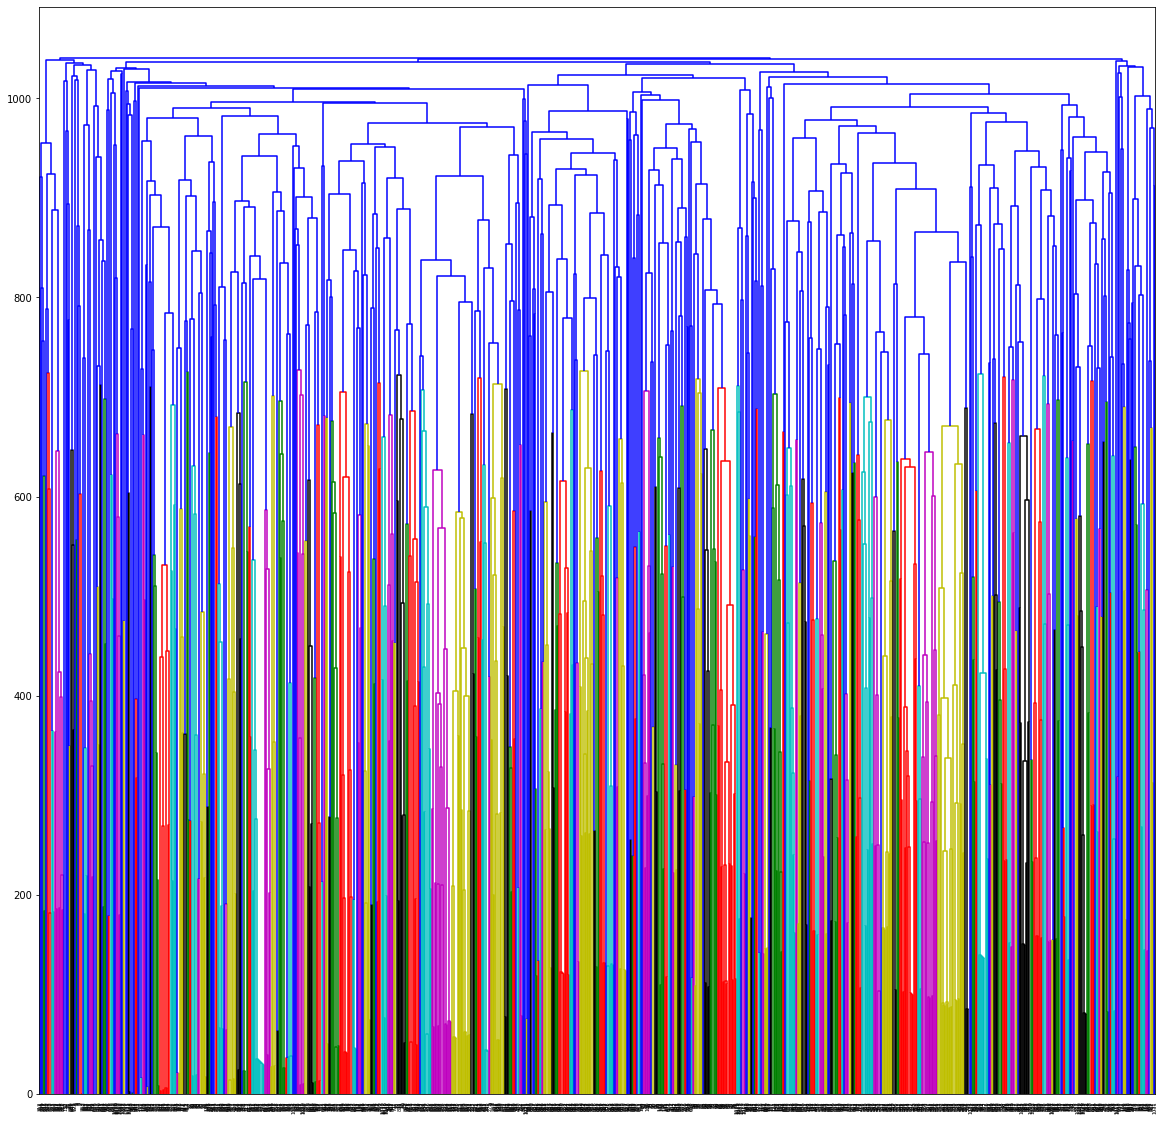

In [ ]:
plt.figure(figsize=(20,20))
plot_dendrogram(clstr)

As expected, this was not a useful visualization.

Let's plot the resulting clusters on a map using the "scatter_geo" function from plotly.express. The map defaults to the entire world; the "scope" parameter is useful for narrowing down the region plotted in the map. The documentation can be found here:

https://www.plotly.express/plotly_express/#plotly_express.scatter_geo


This will provide a much better visual. Do the clusters correspond to geographic areas you would expect? Feel free to experiment with other values for n_cluster and linkage and see how they affect the results.

(the mouse scroll wheel can be used to zoom in and out of the graphic)

In [ ]:
px.scatter_geo(tx_starbucks, lat='Latitude', lon='Longitude', scope='north america', color='label',)

## DBSCAN

Now we will build a DBSCAN clustering model using eps=2 (miles) and min_samples=5. Some notes that may be helpful:

1. Unlike our approach for hierarchical clustering, we do not need to calculate the NxN distance matrix for DBSCAN upfront. It directly supports the haversine distance metric, provided the nearest-neighbors algorithm is a ball tree. Set the "algorithm" and "metric" parameters to the appropriate values. 
2. Scikit-learn's implementation of haversine distance expects radians instead of degrees. Therefore, it would be advisable to create two new columns, Lat_Rad and Lon_Rad, that convert the Latitude and Longitude columns into radians. (Hint: there is a numpy function that does this.)  
3. The eps parameter, which corresponds to the radius of the neighborhood, will also need to be in radians. The conversion factor for miles to radians is approximately 1/3958.748; in other words, if you want the neighborhood to have a radius of 3 miles, set eps = 3/3958.748.  

Side note: ball-tree is an indexing structure that is very useful for nearest-neighbor calculations. The general time-complexity of finding a nearest neighbor using a Ball Tree is O(nlog(n)). This is a vast improvement over the naive O($n^{2}$) and allows us to cluster on much larger subsets of the data, like the entire country. Scikit-learn directly supports creating ball-trees through sklearn.neighbors.BallTree; if inclined, you could extend this analysis to the entire country using a BallTree and cluster Starbucks locations on a much larger scale.


In [ ]:
tx_starbucks['Lat_Rad'] = np.deg2rad(tx_starbucks['Latitude'])
tx_starbucks['Lon_Rad'] = np.deg2rad(tx_starbucks['Longitude'])

In [ ]:
tx_starbucks['Coordinates_Rad'] = list(zip(tx_starbucks['Lat_Rad'], tx_starbucks['Lon_Rad']))

In [ ]:
dbscan_clstr = DBSCAN(eps=(2/3958.748), metric="haversine", min_samples=5)
dbscan_clstr.fit(tx_starbucks[['Lat_Rad', 'Lon_Rad']])

DBSCAN(algorithm='auto', eps=0.0005052102331343141, leaf_size=30,
       metric='haversine', metric_params=None, min_samples=5, n_jobs=None,
       p=None)

In [ ]:
tx_starbucks['dbscan_label'] = dbscan_clstr.labels_

Finally, we plot the resulting clusters on a map using the "scatter_geo" function from plotly.express. The map defaults to the entire world; the "scope" parameter is useful for narrowing down the region plotted in the map. The documentation can be found here:

https://www.plotly.express/plotly_express/#plotly_express.scatter_geo


In [ ]:
 print(f'{tx_starbucks["dbscan_label"].nunique() - 1} Clusters')
 print(f'{tx_starbucks[tx_starbucks["dbscan_label"] == -1].shape[0]} Outliers')

41 Clusters
528 Outliers


In [ ]:
px.scatter_geo(tx_starbucks, lat='Latitude', lon='Longitude', scope='north america', color='dbscan_label',)

We have 41 clusters and a lot of outliers. This would suggest that our definition of neighborhood may have been too strict. Let's fix this to get a better result.

In [ ]:
dbscan_clstr = DBSCAN(eps=(10/3958.748), metric="haversine", min_samples=15)
dbscan_clstr.fit(tx_starbucks[['Lat_Rad', 'Lon_Rad']])

tx_starbucks['dbscan_label'] = dbscan_clstr.labels_

print(f'{tx_starbucks["dbscan_label"].nunique() - 1} Clusters')
print(f'{tx_starbucks[tx_starbucks["dbscan_label"] == -1].shape[0]} Outliers')

px.scatter_geo(tx_starbucks, lat='Latitude', lon='Longitude', scope='north america', color='dbscan_label',)

5 Clusters
181 Outliers


This is much better. Let's think about this from a marketing perspective. Suppose Starbucks wanted to run a targeted ad campaign based on different regions. This clustering arrangement focuses on 5 regions with many Starbucks locations and treats the scattered locations as outliers. This allows Starbucks to tailor their marketing in high density areas, while taking a more broad approach with the outlier locations.